Team Members:

- Gargiulo Michele

- Marchesano Riccardo

- Sabini Pietro

[INFO] - PLEASE RUN THE CELLS IN SECTION 1) IN ORDER. AFTER THAT, SECTION 2)-5) ARE THE FITTING METHODS AND CAN BE RUN INDEPENDENTLY.

# 1) Preliminary Operations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
import os
home = '/content/drive/My Drive/ProgettoSDA2020/Colab'
os.chdir(home)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# The no check certificate parameter is required since the commands returns an error
!wget --no-check-certificate  https://mirror.nohup.it/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!rm spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = home + "/spark-3.0.1-bin-hadoop2.7"

import findspark
findspark.init()

import pyspark
# The number of clusters is just an example since we are using a single machine
NCluster = 4
conf = pyspark.SparkConf().setMaster(f"local[{NCluster}]").setAppName('SDAProject2020Spark')
sc = pyspark.SparkContext(conf=conf)

In [19]:
import pandas as pd
# Reading the dataset file
data = pd.read_csv("dataset.csv")

N = len(data)
n = [None]*2

# Saving the number of approved and not approved railways
for ap in [0,1]:
    isap = data['approved'] == ap
    n[ap] = len(data[isap])

In [ ]:
# Saving and normalizing the features that we will use as predictors
features = [data.columns[i] for i in range(4,12)]
for column in features:
    data[column] = data[column] / max(data[column])

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# This function makes a trick analogue to the use of meshgrid in MATLAB.
# It builds the contour plot of a bivariate Gaussian distribution
# having mean vector and covariance matrix specified in the arguments
def plot_gaussian_3D(mean, cov, xlim=[0,1], ylim=[0,1], xlabel='X Label', ylabel='Y Label', title='Z', cmap=cm.jet):
    # step 1: create the grid
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    # step 2: stack the grid
    xx_yy = np.dstack((xx, yy))
    # step 3: build the plot
    rv = multivariate_normal(mean, cov)
    # step 4: Make a 3D plot
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax = plt.gca(projection='3d')
    ax.plot_surface(xx, yy, rv.pdf(pos), cmap=cmap, linewidth=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# This function prints the confusion matrix and the performance of the method used
def print_fit_performance(Ytest, Yestimated):
    print('Performance...\n')
    print('Confusion matrix:')
    print(confusion_matrix(Ytest, Yestimated))
    print('\n\nClassifier performance metrics:')
    print(classification_report(Ytest, Yestimated))

# This function generates n points on a parabolic curve defined by the values passed as 
# parameters. Returned values are integers
def parabolic_curve(n, a=1, b=0, c=0):
    # generating the points on the curve
    curve = [int(a * x**2 + b*x + c) for x in range(n)]

    # removing identical consecutive values
    for i in range(1,len(curve)):
        curve[i] = max(curve[i-1]+1, curve[i])
        
    return curve

# This funciton generates n points on a parabolic curve defined by the values passed as 
# parameters. Returned values are floats
def parabolic_curve_float(n, a=1, b=0, c=0, precision=4):
	# generating the points on the curve
    curve = [round(a*x**2 + b*x + c, precision) for x in range(n)]

    # removing identical consecutive values depending on precision
    for i in range(1, len(curve)):
        curve[i] = round(max(curve[i-1] + 10**(-precision), curve[i]), precision)

    return curve

# This function returns the most common value in a dictionary
def most_common(x):
    return max(set(x), key=list(x).count)

# This function splits the dataset into 3 parts: train, test and validation set
def train_test_val_split(X, Y, test_size=0.3, val_size=0.2):
    if not 0 < test_size < 1 or not 0 < val_size < 1:
        raise ValueError("test_size and val_size must be in ]0,1[")

    if not test_size + val_size < 1:
        raise ValueError("the sum of test_size and val_size must be less than 1")

    # first split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size+val_size)

    # second split, rescaling the split size to match 1
    val_size /= val_size + test_size
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=val_size)

    return X_train, X_test, X_val, Y_train, Y_test, Y_val

# This function prints the plot of a sigmoid function
def plot_sigmoid(XX, YY, w, title='Decision Regions'):

    f = plt.figure()

    # step 0: plot the training set
    plt.scatter(XX[:, 0], XX[:, 1], c=YY, cmap='RdBu')
    # step 1: get the boundaries of the grid
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # step 2: create the grid
    yy, xx = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
    # step 3: compute the function values for any x in xx and y in yy
    pp = np.divide(1, 1 + np.exp(- w[0] - w[1]*xx - w[2]*yy));  
    # step 4: plot decision boundary and margin
    contour = ax.contourf(xx, yy, pp, 25, cmap="RdBu", alpha=0.6,
                          levels=[i/10 for i in range(11)], zorder=0)
    ax.set_title(title)
    f.colorbar(contour)
    plt.show()

In [ ]:
#################
# Data Analysis #
#################

In [ ]:
for ap in [0,1]:
    print(f'{ap}: {n[ap] / N * 100: .2f}%')

0:  50.41%
1:  49.59%


In [ ]:
# These values will be used to train the predictors with only two features
f1_name = 'final_vote'
f2_name = 'expendiency_score'

f1 = [None]*2
f2 = [None]*2

mean = {
    f1_name: [None]*2,
    f2_name: [None]*2,
}
var = {
    f1_name: [None]*2,
    f2_name: [None]*2,
}
# since approved is a binary value, it can be represented as a 0 or a 1
for ap in [0,1]:
    # selecting all the rows that have the column approved set to 0,
    # then to 1. The selection is executed with the pandas library
    isap = data['approved'] == ap
    # saving the two rows in two lists
    f1[ap] = data[isap][f1_name]
    f2[ap] = data[isap][f2_name]
    # computing mean and variance of the selected features (f1 and f2)
    mean[f1_name][ap] = f1[ap].mean()
    var[f1_name][ap] = f1[ap].var()
    mean[f2_name][ap] = f2[ap].mean()
    var[f2_name][ap] = f2[ap].var()

m = mean[f1_name]
v = var[f1_name]
print(f'For approved railways, the {f1_name} mean is {m[1]:.4f} with variance {v[1]:.4f}\n'
      f'For not approved railways, the {f1_name} mean is {m[0]:.4f} with variance {v[0]:.4f}')

m = mean[f2_name]
v = var[f2_name]
print(f'\nFor approved railways, the {f2_name} mean is {m[1]:.4f} with variance {v[1]:.4f}\n'
      f'For not approved railways, the {f2_name} mean is {m[0]:.4f} with variance {v[0]:.4f}')

For approved railways, the final_vote mean is 0.8334 with variance 0.0233
For not approved railways, the final_vote mean is 0.2159 with variance 0.0232

For approved railways, the expendiency_score mean is 0.8619 with variance 0.0237
For not approved railways, the expendiency_score mean is 0.3430 with variance 0.0368


In [ ]:
data[features].cov()

,final_vote,comfort_score,service_score,food_score,enjoyment_score,station_score,internet_connection_score,expendiency_score
final_vote,0.118551,0.073553,0.085274,0.076758,0.068142,0.089051,0.068952,0.094942
comfort_score,0.073553,0.078240,0.057486,0.054355,0.052067,0.057724,0.051710,0.063570
service_score,0.085274,0.057486,0.094929,0.065439,0.053336,0.066482,0.055449,0.071048
food_score,0.076758,0.054355,0.065439,0.084789,0.055957,0.057919,0.054678,0.065237
enjoyment_score,0.068142,0.052067,0.053336,0.055957,0.088056,0.053412,0.062215,0.057538
station_score,0.089051,0.057724,0.066482,0.057919,0.053412,0.100458,0.056881,0.074622
internet_connection_score,0.068952,0.051710,0.055449,0.054678,0.062215,0.056881,0.094365,0.060219
expendiency_score,0.094942,0.063570,0.071048,0.065237,0.057538,0.074622,0.060219,0.097626


In [ ]:
import numpy as np
from sklearn.utils import shuffle

X = [None]*2
Y = [None]*2

m = [None]*2
c = [None]*2
v = [None]*2

n_samples = [None]*2

# For approved and not approved railways we calculate the mean and
# the variance, in order to get a syntetic distribution and get a general idea
# of the data distribution. We are assuming that the distribution is a 
# normal multivariate.
for ap in [0,1]:
    n_samples[ap] = n[ap]
    isap = data['approved'] == ap
    covariance = data[isap][f1_name].cov(data[isap][f2_name])
    m[ap] = [mean[f1_name][ap], mean[f2_name][ap]]
    c[ap] = [[var[f1_name][ap], covariance],
              [covariance, var[f2_name][ap]]]
    v[ap] = [var[f1_name][ap], var[f2_name][ap]]

    X[ap] = np.random.multivariate_normal(m[ap], c[ap], n_samples[ap])
    Y[ap] = np.ones((n_samples[ap], 1)) * ap

# merging and shuffling the generated dataset
XX = np.vstack((X[0], X[1]))
YY = np.vstack((Y[0], Y[1]))
XX, YY = shuffle(XX, YY)

# 2) NAÏVE BAYES

In [ ]:
from sklearn.naive_bayes import GaussianNB

# This function fits a certain dataset using the Gaussian Naive Bayes classifier
def GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=True):
    gnb = GaussianNB()
    YY_estimated = gnb.fit(XX_train, YY_train).predict(XX_test)
    performance = gnb.score(XX_test, YY_test)

    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance

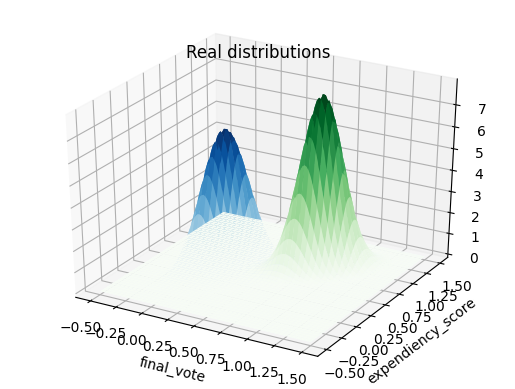

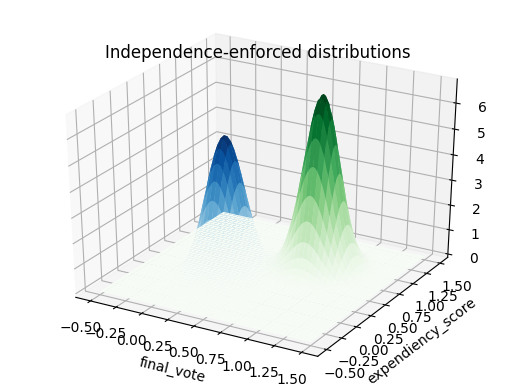

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Here we are plotting two distributions

limits = {
    'x': [-0.5, 1.5],
    'y': [-0.5, 1.5]
}
colors = {
    0: cm.Blues,
    1: cm.Greens
}

# The first is the real one, with the correct values of covariance.
plt.figure()
for ap in [0,1]:
    plot_gaussian_3D(m[ap], c[ap], xlim=limits['x'], ylim=limits['y'],
                     xlabel=f1_name, ylabel=f2_name, title='Real distributions', cmap=colors[ap])
plt.show()

# The second is the one used by the Naïve-Bayes classifier, which assumes that
# the covariances are 0 as the features are supposed independent
plt.figure()
for ap in [0,1]:
    plot_gaussian_3D(m[ap], v[ap], xlim=limits['x'], ylim=limits['y'],
                     xlabel=f1_name, ylabel=f2_name, title='Independence-enforced distributions',
                     cmap=colors[ap])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performance...

Confusion matrix:
[[11722   258]
 [  259 11634]]


Classifier performance metrics:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     11980
         1.0       0.98      0.98      0.98     11893

    accuracy                           0.98     23873
   macro avg       0.98      0.98      0.98     23873
weighted avg       0.98      0.98      0.98     23873

final performance:  97.83%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fit with only two features
X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['approved']

# Split the real dataset
XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performance...

Confusion matrix:
[[11457   557]
 [  476 11383]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12014
           1       0.95      0.96      0.96     11859

    accuracy                           0.96     23873
   macro avg       0.96      0.96      0.96     23873
weighted avg       0.96      0.96      0.96     23873

final performance:  95.67%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

# Now we fit the Naïve Bayes classifier using one feature at a time.
# So we select only one feature, then we train the classifier and append the
# final result to a list
res = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['approved']
    
    # Split the real dataset
    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

# Print a table
table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]), features, tablefmt="table")
print(table)

final_vote    comfort_score    service_score    food_score    enjoyment_score    station_score    internet_connection_score    expendiency_score
------------  ---------------  ---------------  ------------  -----------------  ---------------  ---------------------------  -------------------
95.46%        81.90%           86.15%           81.91%        77.44%             84.15%           77.31%                       90.51%


In [ ]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
# Now we calculate all the possible couples of features, then we train the classifier with each of
# them and append the final result to a list
for (x1,x2) in combinations(features, 2):
    X_real = pd.concat([data[x1], data[x2]], axis=1)
    Y_real = data['approved']

    # Split the real dataset
    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

# Print a table
table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]),
                 [f"{x1} + {x2}" for (x1,x2) in combinations(features, 2)],
                 tablefmt="table")
print(table)

final_vote + comfort_score    final_vote + service_score    final_vote + food_score    final_vote + enjoyment_score    final_vote + station_score    final_vote + internet_connection_score    final_vote + expendiency_score    comfort_score + service_score    comfort_score + food_score    comfort_score + enjoyment_score    comfort_score + station_score    comfort_score + internet_connection_score    comfort_score + expendiency_score    service_score + food_score    service_score + enjoyment_score    service_score + station_score    service_score + internet_connection_score    service_score + expendiency_score    food_score + enjoyment_score    food_score + station_score    food_score + internet_connection_score    food_score + expendiency_score    enjoyment_score + station_score    enjoyment_score + internet_connection_score    enjoyment_score + expendiency_score    station_score + internet_connection_score    station_score + expendiency_score    internet_connection_score + expendiency_s

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Here we perform a complete fit, using all features
X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['approved']

# Split the real dataset
XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

GNB_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performance...

Confusion matrix:
[[11537   588]
 [  609 11139]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12125
           1       0.95      0.95      0.95     11748

    accuracy                           0.95     23873
   macro avg       0.95      0.95      0.95     23873
weighted avg       0.95      0.95      0.95     23873

final performance:  94.99%


# 3) KNN

In [ ]:
from math import sqrt
import numpy as np
import heapq

# This function is used by Spark to calculate the euclidean distance between 
# the test value in broadcast and the one passed as parameter. 
# This function is called when the cluster is finding the KNNs
# in each partition
def euclidean_distance(yx_train):
    global x_test_br
    x_train = yx_train[1:]  # the first column of yx_train is the label
    distance = 0.0
    for i in range(len(x_train)):
        distance += (x_train[i] - x_test_br.value[i])**2
    return sqrt(distance)

# This function is used by Spark to get the K point with the minimum euclidean distance
# wrt a given point
def K_nearest_neighbors(collection):
    global K_br
    return np.array(heapq.nsmallest(K_br.value, collection, euclidean_distance))

In [ ]:
import numpy as np
from operator import add


K_br = None
x_test_br = None


def KNN_fit_spark(K, XX_train, XX_test, YY_train):
    # create whole dataset
    YY__XX_train = np.column_stack((YY_train, XX_train))
    
    # parallelize the dataset
    rdd = sc.parallelize(YY__XX_train).cache()

    # broadcast K
    global K_br
    K_br = sc.broadcast(K)

    # YY_estimated will contain the estimated class for each x_test
    YY_estimated = []
    for x_test in XX_test:
        # broadcast each test value
        global x_test_br
        x_test_br = sc.broadcast(x_test)

        # find the K nearest neighbors with respect to x_test_br
        KNN = K_nearest_neighbors(rdd.mapPartitions(K_nearest_neighbors).collect())

        # parallelize all the neighbors label
        KNN_rdd = sc.parallelize(KNN[:,0]).cache()

        # compute the number of ones in the partitions
        total_ones = KNN_rdd.reduce(add)

        # the estimated label is the most common value in KNN's labels
        YY_estimated.append(int(total_ones > K/2))

    return np.array(YY_estimated)

In [ ]:
from sklearn import neighbors
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Fits the KNN classifier, using K neighbors. If the use_spark flag is set 
# to True, then the classification is performed using the Spark 
# implementation too.
# Returns the performances and the MSE of the KNN implemented in sklearn. 
# Raises exception if the estimations of the two classifiers (sklearn and Spark) are different
def KNN_fit_and_predict(K, XX_train, XX_test, XX_val, YY_train, YY_test, YY_val,
                        use_spark=False, plot_flag=False, verbose=True):

    # we create an instance of Neighbours Classifier and fit the data.
    knn = neighbors.KNeighborsClassifier(K, weights='uniform')
    YY_estimated = knn.fit(XX_train, YY_train).predict(XX_val)
    performance = knn.score(XX_test, YY_test)

    # try with spark...
    if use_spark:
        YY_estimated_spark = KNN_fit_spark(K, XX_train, XX_val, YY_train)
        if not np.array_equal(YY_estimated, YY_estimated_spark):
            raise Exception("Bad implementaion of KNN with Spark!")

    if plot_flag:
        # Create color maps
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
        cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])

        # init vars
        h = .02 # step size in the mesh
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = XX[:, 0].min() - 1, XX[:, 0].max() + 1
        y_min, y_max = XX[:, 1].min() - 1, XX[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        fig = plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        plt.scatter(XX_train[:, 0], XX_train[:, 1], c=YY_train, cmap=cmap_bold, edgecolor='k', s=20)   
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"0/1 outcome classification (K={K})")
        plt.show()

    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance, mean_squared_error(YY_val, YY_estimated)

# Finds the best K parameter, trying with nk different values less than maxK.
# Plots the decision regions each n_plot_steps K values
def KNN_tuning(XX, YY, maxK=1000, nk=31, n_plot_steps=None,
               use_spark=False, best_K_plot_flag=False, verbose=1):

    # MSEs dictionary for each K
    mses = {}
    # Performance dictionary for each K
    perf = {}

    # KK will be distributed as a parabolic curve f such that f(0)=1 and f(nk-1)=maxK
    KK = parabolic_curve(nk, a=(maxK-1)/(nk - 1)**2, b=0, c=1)

    if verbose == 2:
        print(f'Trying for K={KK}')

    # split data into training, test and validation set
    XX_train, XX_test, XX_val, YY_train, YY_test, YY_val = train_test_val_split(XX, YY, 0.3, 0.2)

    for i in range(len(KK)):
        K = KK[i]

        plot_flag = (i%n_plot_steps==0) if n_plot_steps is not None else False
        perf[K], mses[K] = KNN_fit_and_predict(K, XX_train, XX_test, XX_val,
                                               YY_train, YY_test, YY_val,
                                               use_spark=use_spark,
                                               plot_flag=plot_flag, verbose=False)
        
        if verbose == 2:
            print(f"K = {K}, MSE = {mses[K]: .4}")

    best_K = min(mses, key=mses.get)
    best_mse = mses[best_K]
    best_perf = perf[best_K]
    
    if best_K_plot_flag:
        plt.figure()
        plt.plot(KK, list(mses.values()))
        plt.xlabel('K')
        plt.ylabel('Test error')
        plt.title("Performance")      
        r = (min(mses.values()), max(list(mses.values())))
        plt.annotate(f'{best_mse:.3} for K={best_K}', xy=(best_K, best_mse),
                    xytext=(0.4*max(KK), r[0] + 0.4*(r[1]- r[0])),
                    arrowprops=dict(facecolor='black', headwidth=10, shrink=0.1))
        plt.show()

    if verbose:
        print(f"Final performance: {best_perf * 100: .2f}%")

    return best_K, best_mse, best_perf

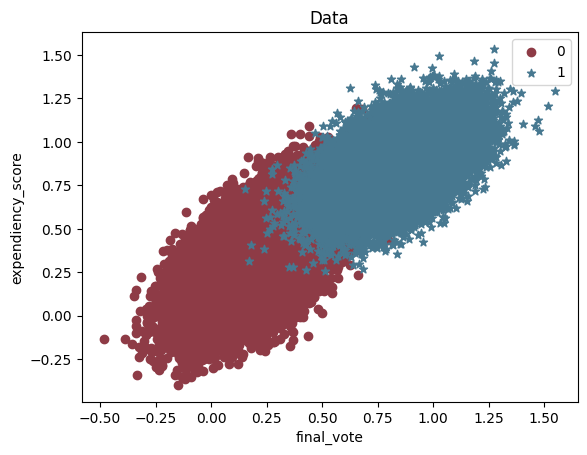

In [ ]:
import matplotlib.pyplot as plt

# Plot the synthetic dataset in order to visualize it

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for ap in [0,1]:
    plt.scatter(X[ap][:, 0], X[ap][:, 1], color=color[ap], marker=marker[ap], label=str(ap))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

In [ ]:
#@markdown Select KNN fit parameters

N_sample = 5000 #@param {type:"integer"}
maxK =  2000 #@param {type:"integer"}
nk = 25 #@param {type:"integer"}


In [ ]:
# Fitting the KNN classifier on the synthetic dataset.
# Only a subset of the whole dataset is used due to time reasons, as
# the results are compared with the ones produced by our custom
# classifier with Spark
KNN_tuning(XX[:N_sample], YY[:N_sample], maxK=maxK, nk=nk,
           n_plot_steps=3, use_spark=True, best_K_plot_flag=True, verbose=2);

Trying for K=[1, 4, 14, 32, 56, 87, 125, 171, 223, 282, 348, 420, 500, 587, 681, 781, 889, 1003, 1125, 1253, 1389, 1531, 1680, 1836, 2000]


KeyboardInterrupt: ignored

In [ ]:
#@markdown Select KNN fit parameters

maxK = 2000 #@param {type:"integer"}
nk = 25 #@param {type:"integer"}

In [ ]:
import pandas as pd

# Fit with only two features
X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['approved']

# Tuning the K value
KNN_tuning(X_real.values, Y_real.values, maxK=maxK, nk=nk,
           best_K_plot_flag=True, verbose=2);

In [ ]:
#@markdown Select KNN fit parameters

maxK = 2000 #@param {type:"integer"}
nk = 25 #@param {type:"integer"}

In [ ]:
import pandas as pd
from tabulate import tabulate
import numpy as np

# Now we fit the KNN classifier using one feature at a time.
# So we select only one feature, then we train the classifier and append the
# final result to a list

best_k = []
best_mse = []
best_score = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['approved']

    print(f"***Fitting with '{feature}' feature")
    # Tuning the K value
    k, mse, score = KNN_tuning(X_real.values, Y_real.values, maxK=maxK, nk=nk,
                              best_K_plot_flag=True, verbose=2)
    best_k.append(k)
    best_mse.append(mse)
    best_score.append(score)

# Print a table
table = tabulate(np.array([['K'] + [f'{k}' for k in best_k],
                           ['MSE'] + [f'{mse*100:.2f}%' for mse in best_mse],
                           ['Score'] + [f'{score*100:.2f}%' for score in best_score]]),
                 features, tablefmt="table")
print(table)

In [ ]:
#@markdown Select KNN fit parameters

maxK = 2000 #@param {type:"integer"}
nk = 25 #@param {type:"integer"}

In [ ]:
import pandas as pd

# Here we perform a complete fit, using all features

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['approved']

# Tuning the K value
KNN_tuning(X_real.values, Y_real.values, maxK=maxK, nk=nk,
           best_K_plot_flag=True, verbose=2);

# 4) LOGISTIC REGRESSION

In [ ]:
import numpy as np
from operator import add

# Sigmoid function in range ]0,1[. Returns 1/(1+e^-x)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Returns the gradient on a single point in the training set
def compute_gradient(yx_train):
    global w_br
    x = yx_train[1:]
    y = -1 + 2 * yx_train[0]

    w_dot_x = w_br.value @ x.T
    gradient = -y * (1 - sigmoid(y * w_dot_x)) * x
    return gradient

# Returns the cost value, computed with the respect to the dataset X, the current weight w
# and the actual labels Y
def compute_cost(X, Y, w):
    h = sigmoid(X @ w)
    epsilon = 1e-5
    cost = (1 / len(Y)) * (((-Y).T @ np.log(h + epsilon)) - ((1 - Y).T @ np.log(1 - h + epsilon)))
    return cost

# Performs the gradient descent algorithm. Returns the cost history and 
# the optimal parameters
def gradient_descent(YY__XX_train, w, learning_rate, momentum, iterations):
    global w_br

    RDD_train = sc.parallelize(YY__XX_train).cache()

    cost_history = np.zeros((iterations,1))
    
    for i in range(iterations):     
        gradient = RDD_train.map(compute_gradient).reduce(add)
        w = w - learning_rate * (gradient/(N//2) + momentum * w)
        
        cost_history[i] = compute_cost(YY__XX_train[:, 1:],
                                       YY__XX_train[:, 0].reshape(len(YY__XX_train), 1),
                                       w.reshape(len(w), 1))
        w_br = sc.broadcast(w)

    return cost_history, w

# Returns the predicted label for X, given the parameter vector
def predict(X, w):
    return np.round(sigmoid(X @ w.reshape(len(w), 1)))

In [ ]:
#@markdown Select Logistic Regression fit hyperparameters

iterations = 2000 #@param {type:"integer"}
learning_rate = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
momentum = 0 #@param {type:"integer"}




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w_br = None

# Fits a logistic regressor using Spark clusters, with a custom algorithm.
# Returns the predicted labels for the test set
def LogReg_fit_spark(XX_train, XX_test, YY_train, YY_test):
    global w_br

    # Put a column of ones on the left side of XX_train and XX_test
    XX_train_ones = np.hstack((np.ones((len(XX_train),1)), XX_train))
    XX_test = np.hstack((np.ones((len(XX_test),1)), XX_test))
    YY__XX_train = np.column_stack((YY_train, XX_train_ones))

    # Initialize a vector for the parameters and broadcast it
    w = np.zeros((np.size(XX_train_ones, 1), 1)).flatten()
    w_br = sc.broadcast(w)

    # Compute the optimal parameters and save the cost history
    cost_history, w_hat = gradient_descent(YY__XX_train, w, learning_rate, momentum, iterations)

    # Plot the convergence graph of the cost function
    plt.figure()
    plt.plot(range(len(cost_history)), cost_history, 'r')
    plt.title("Convergence Graph of Cost Function")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()

    # Predict the test set labels and compute the score 
    y_pred = predict(XX_test, w_hat)
    score = float(sum(y_pred == YY_test))/ float(len(YY_test))
    print(f"Performance using Spark: {score:.4f}")

    # Plot the classification probability regions
    plot_sigmoid(XX_train, YY_train, w_hat, title='Data classification')

    return y_pred

In [ ]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

# Fit a logistic regression model using the sklearn library.
# Returns the performance of the model
def LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, plot_flag=False, verbose=True):
    lr = SGDClassifier('log')
    YY_estimated = lr.fit(XX_train, YY_train).predict(XX_test)
    performance = lr.score(XX_test, YY_test)

    if plot_flag:
        f = plt.figure()
        plt.title('Data classification')

        # step 0: plot the training set
        plt.scatter(XX_train[:, 0], XX_train[:, 1], c=YY_train, cmap='RdBu', zorder=2)         
        # step 1: getting the boundaries of the grid
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        # step 2: creating the grid
        yy, xx = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(xlim[0], xlim[1], 30))
        # step 3: stacking the grid
        xx_yy = np.vstack([xx.ravel(), yy.ravel()]).T
        # step 4: computing the related hyperplane values and unstacking
        pp = lr.predict_proba(xx_yy)[:, 1].reshape(xx.shape)
        # step 5: plot decision boundary and margin
        contour = ax.contourf(xx, yy, pp, 25, cmap="RdBu",
                              alpha=0.6, levels=[i/10 for i in range(11)], zorder=0)
        f.colorbar(contour)
        plt.show()
    
    if verbose:
        print_fit_performance(YY_test, YY_estimated)
        print(f"final performance: {performance * 100: .2f}%")

    return performance

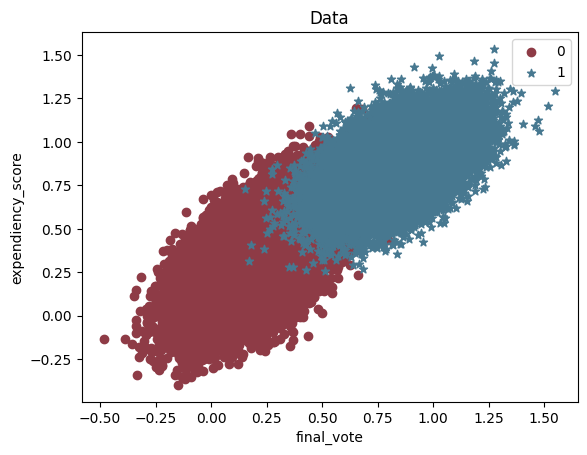

In [ ]:
import matplotlib.pyplot as plt

# Plot the synthetic dataset in order to visualize it

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for ap in [0,1]:
    plt.scatter(X[ap][:, 0], X[ap][:, 1], color=color[ap], marker=marker[ap], label=str(ap))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

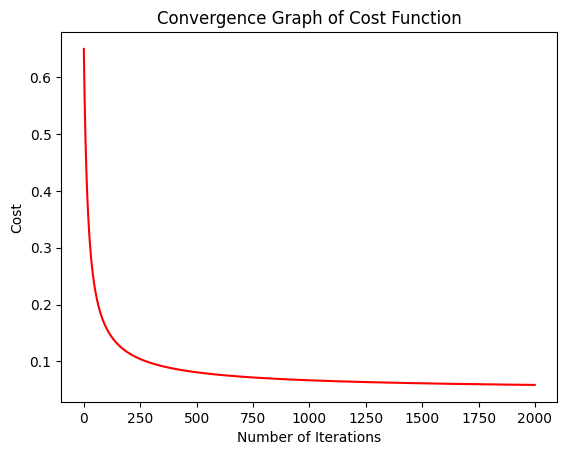

Performance using Spark: 0.9799


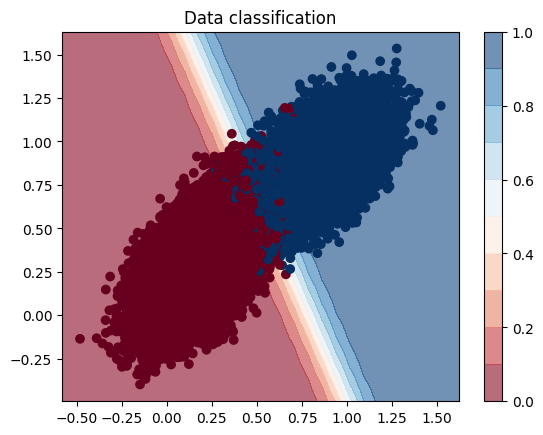

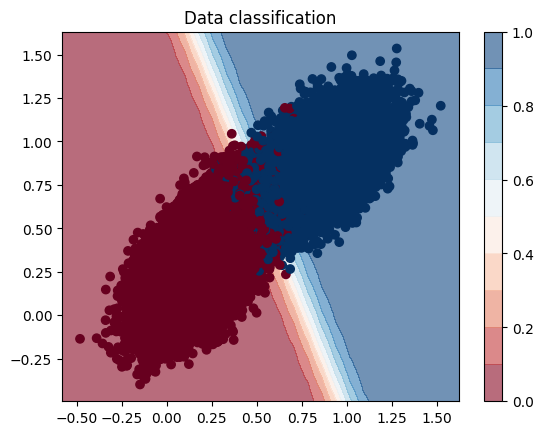

Performance...

Confusion matrix:
[[11794   216]
 [  264 11599]]


Classifier performance metrics:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     12010
         1.0       0.98      0.98      0.98     11863

    accuracy                           0.98     23873
   macro avg       0.98      0.98      0.98     23873
weighted avg       0.98      0.98      0.98     23873

final performance:  97.99%


In [ ]:
from sklearn.model_selection import train_test_split

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.3)

# Fit with both library and custom algorithms and compare the results
LogReg_fit_spark(XX_train, XX_test, YY_train, YY_test)
LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, True, True);

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['approved']

XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performance...

Confusion matrix:
[[11460   616]
 [  481 11316]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12076
           1       0.95      0.96      0.95     11797

    accuracy                           0.95     23873
   macro avg       0.95      0.95      0.95     23873
weighted avg       0.95      0.95      0.95     23873

final performance:  95.40%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['approved']

    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]), features, tablefmt="table")
print(table)

final_vote    comfort_score    service_score    food_score    enjoyment_score    station_score    internet_connection_score    expendiency_score
------------  ---------------  ---------------  ------------  -----------------  ---------------  ---------------------------  -------------------
95.35%        82.04%           86.37%           81.97%        77.30%             84.50%           77.41%                       87.99%


In [ ]:
from itertools import combinations
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import numpy as np

res = []
for (x1,x2) in combinations(features, 2):
    X_real = pd.concat([data[x1], data[x2]], axis=1)
    Y_real = data['approved']

    XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

    res.append(LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test, verbose=False))

table = tabulate(np.array([[f'{r*100:.2f}%' for r in res]]),
                 [f"{x1} + {x2}" for (x1,x2) in combinations(features, 2)],
                 tablefmt="table")
print(table)

final_vote + comfort_score    final_vote + service_score    final_vote + food_score    final_vote + enjoyment_score    final_vote + station_score    final_vote + internet_connection_score    final_vote + expendiency_score    comfort_score + service_score    comfort_score + food_score    comfort_score + enjoyment_score    comfort_score + station_score    comfort_score + internet_connection_score    comfort_score + expendiency_score    service_score + food_score    service_score + enjoyment_score    service_score + station_score    service_score + internet_connection_score    service_score + expendiency_score    food_score + enjoyment_score    food_score + station_score    food_score + internet_connection_score    food_score + expendiency_score    enjoyment_score + station_score    enjoyment_score + internet_connection_score    enjoyment_score + expendiency_score    station_score + internet_connection_score    station_score + expendiency_score    internet_connection_score + expendiency_s

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['approved']

XX_train, XX_test, YY_train, YY_test = train_test_split(X_real, Y_real, test_size=0.3)

LogReg_fit_and_predict(XX_train, XX_test, YY_train, YY_test);

Performance...

Confusion matrix:
[[11521   477]
 [  523 11352]]


Classifier performance metrics:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11998
           1       0.96      0.96      0.96     11875

    accuracy                           0.96     23873
   macro avg       0.96      0.96      0.96     23873
weighted avg       0.96      0.96      0.96     23873

final performance:  95.81%


# 5) NAÏVE KERNEL

In [ ]:
from math import sqrt
import numpy as np

# This function is used by spark to calculate the euclidean distance between 
# the value in broadcast and the one passed as parameter. 
# This function is called when the cluster is filtering the neighbour in a
# fixed range
def euclidean_distance(yx_train):
    global x_test_br
    x_train = yx_train[1:] # the first column of xy_train is the label
    distance = 0.0
    for i in range(len(x_train)):
        distance += (x_train[i] - x_test_br.value[i])**2
    return sqrt(distance)

# This function is used by spark to get the values that are in a fixed 
# range, computing the euclidean distance from a given point
def neighbors_in_h(collection):
    global h_br
    return np.array(list(filter(lambda x: euclidean_distance(x) <= h_br.value, collection)))

In [ ]:
import numpy as np
from operator import add
from random import randint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


h_br = None
x_test_br = None


def NaiveKernel_fit_and_predict(h, XX_train, XX_test, XX_val, YY_train, YY_test, YY_val):
    # create whole dataset
    YY__XX_train = np.column_stack((YY_train, XX_train))
    
    # parallelize the dataset
    rdd = sc.parallelize(YY__XX_train).cache()

    # broadcast K
    global h_br
    h_br = sc.broadcast(h)

    # YY_estimated will contain the estimated class for each x_test
    YY_estimated = []
    for x_test in XX_test:
        # broadcast each test value
        global x_test_br
        x_test_br = sc.broadcast(x_test)

        # find the neighbors wrt x_test_br
        neighbors = rdd.mapPartitions(neighbors_in_h).collect()
        labels = [x[0] for x in neighbors]

        if len(labels) > 0:
            # parallelize all the neighbors label
            neighbors_rdd = sc.parallelize(labels).cache()

            # compute the number of ones in the partitions
            total_ones = neighbors_rdd.reduce(add)

            # the estimated label is the most common value in neighbors' labels
            YY_estimated.append(int(total_ones > len(neighbors)/2))
        else:
            YY_estimated.append(randint(0,1))

    YY_estimated = np.array(YY_estimated)
    YY_test = YY_test.flatten()
    score = sum(YY_estimated == YY_test) / len(YY_test)

    YY_estimated = []
    for x_test in XX_val:
        # broadcast each test value
        x_test_br = sc.broadcast(x_test)

        # find the neighbors wrt x_test_br
        neighbors = rdd.mapPartitions(neighbors_in_h).collect()
        labels = [x[0] for x in neighbors]

        if len(labels) > 0:
            # parallelize all the neighbors label
            neighbors_rdd = sc.parallelize(labels).cache()

            # compute the number of ones in the partitions
            total_ones = neighbors_rdd.reduce(add)

            # the estimated label is the most common value in neighbors' labels
            YY_estimated.append(int(total_ones > len(neighbors)/2))
        else:
            YY_estimated.append(randint(0,1))

    return score, mean_squared_error(YY_val, np.array(YY_estimated))


def NaiveKernel_tuning(XX, YY, minh=0.2, maxh=0.5, nh=10, test_size=0.3, val_size=0.2,
                       best_h_plot_flag=False, verbose=1):
    # split data into training, test and validation set
    XX_train, XX_test, XX_val, YY_train, YY_test, YY_val = train_test_val_split(XX, YY, test_size, val_size)
    
    # MSEs dictionary for each K
    mses = {}
    perf = {}

    # Parabolic curve f such that f(0)=minh and f(nk-1)=maxh
    hh = parabolic_curve_float(nh, a=(maxh - minh) / (nh - 1)**2, b=0, c=minh)

    if verbose == 2:
        print(f'Trying for h={hh}')

    for i in range(len(hh)):
        h = hh[i]

        perf[h], mses[h] = NaiveKernel_fit_and_predict(h, XX_train, XX_test, XX_val,
                                                       YY_train, YY_test, YY_val)
        
        if verbose == 2:
            print(f"h = {h}, MSE = {mses[h]: .4}")

    best_h = min(mses, key=mses.get)
    best_mse = mses[best_h]
    best_perf = perf[best_h]
    
    if best_h_plot_flag:
        plt.figure()
        plt.plot(hh, list(mses.values()))
        plt.xlabel('h')
        plt.ylabel('Test error')
        plt.title("Performance")      
        r = (min(mses.values()), max(list(mses.values())))
        plt.annotate(f'{best_mse:.3} for h={best_h}', xy=(best_h, best_mse),
                    xytext=(0.4*max(hh), r[0] + 0.4*(r[1]- r[0])),
                    arrowprops=dict(facecolor='black', headwidth=10, shrink=0.1))
        plt.show()

    if verbose:
        print(f"Final performance: {best_perf * 100: .2f}%")

    return best_h, best_mse, best_perf

In [ ]:
import matplotlib.pyplot as plt

color = {
    0: '#8e3b46',
    1: '#477890'
}
marker = {
    0: 'o',
    1: '*'
}

plt.figure()
plt.title('Data')
for ap in [0,1]:
    plt.scatter(X[ap][:, 0], X[ap][:, 1], color=color[ap], marker=marker[ap], label=str(ap))
plt.xlabel(f1_name)
plt.ylabel(f2_name)
plt.legend()
plt.show()

In [ ]:
#@markdown Select Naive-Kernel parameters

N_sample =  7000 #@param {type:"integer"}
minh =  0.01 #@param {type:"raw"}
maxh = 0.5 #@param {type:"raw"}
nh =  10#@param {type:"integer"}


In [ ]:
NaiveKernel_tuning(XX[:N_sample], YY[:N_sample], minh=minh, maxh=maxh, nh=nh,
                   test_size=0.3, val_size=0.2,
                   best_h_plot_flag=True, verbose=2);

In [ ]:
#@markdown Select Naive-Kernel parameters

N_sample =  5000 #@param {type:"integer"}
minh = 0.2*sqrt(2) #@param {type:"raw"}
maxh = sqrt(2) #@param {type:"raw"}
nh =  6 #@param {type:"integer"}


In [ ]:
import pandas as pd

X_real = pd.concat([data[f1_name], data[f2_name]], axis=1)
Y_real = data['approved']

NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                   minh=minh, maxh=maxh, nh=nh, best_h_plot_flag=True, verbose=2);

In [ ]:
#@markdown Select Naive-Kernel parameters

N_sample =  5000 #@param {type:"integer"}
minh = 0.2*sqrt(2) #@param {type:"raw"}
maxh = 0.5*sqrt(2) #@param {type:"raw"}
nh =  6 #@param {type:"integer"}


In [ ]:
import pandas as pd
from tabulate import tabulate
import numpy as np

best_h = []
best_mse = []
best_score = []
for feature in features:
    X_real = pd.concat([data[feature]], axis=1)
    Y_real = data['approved']

    print(f"***Fitting with '{feature}' feature")
    h, mse, score = NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                                       minh=minh, maxh=maxh, nh=nh,
                                       best_h_plot_flag=True, verbose=2)
    best_h.append(h)
    best_mse.append(mse)
    best_score.append(score)

table = tabulate(np.array([['h'] + [f'{h}' for h in best_h],
                           ['MSE'] + [f'{mse*100:.2f}%' for mse in best_mse],
                           ['Score'] + [f'{score*100:.2f}%' for score in best_score]]),
                 features, tablefmt="table")
print(table)

In [ ]:
#@markdown Select Naive-Kernel parameters

N_sample =  7000 #@param {type:"integer"}
minh = 0.2*sqrt(2) #@param {type:"raw"}
maxh = sqrt(2) #@param {type:"raw"}
nh =  6 #@param {type:"integer"}


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt

X_real = pd.concat([data[feature] for feature in features], axis=1)
Y_real = data['approved']

NaiveKernel_tuning(X_real[:N_sample].values, Y_real[:N_sample].values,
                   minh=minh, maxh=maxh, nh=nh,
                   best_h_plot_flag=True, verbose=2);sdsgigssvcbagfgsbcbchdbscjshbdshdsjsbdhbdfjshbdfhsjbdfjhsbdfjbhsdhf